In [1]:
import pandas as pd
import numpy as np

In [2]:
kadaster = pd.read_csv("kadaster/kadaster_merged_dataset_corrected.csv", dtype=str)
sbi = pd.read_csv("kvk/sbi_codes/kvk_sbi_codes.csv", dtype=object)
kvk = pd.read_excel("kvk/DatasetKvK01102019.xls", dtype=object)
niwo = pd.read_csv("niwo/niwo_dict.csv", dtype=object)
fenex = pd.read_csv("fenex/fenex.csv", dtype=object)
company_info = pd.read_csv("company_info/kvk_companyinfo.csv", dtype=object)

In [3]:
kvk_drop = ['RGL','STRVA', 'PCPLVA', 'STRCA', 'PCPLCA','HN1X30', 'HN1X2X30', 'HN2X2X30', \
            'PCCA', 'GEMK_VA', 'GEMK_CA', 'GEMNAAM', 'PROV', 'STRAAT_VA', \
            'TOEV_VA', 'PC_VA', 'PLAATS_VA', 'STRAAT_CA', 'HUISNR_CA', \
            'TOEV_CA', 'PC_CA', 'PLAATS_CA', 'NMI', 'HFD_N_VEST', 'C_HOOFDACT', 'VERK_ACT', \
            'NEVEN1', 'NEVEN2', 'IND_IM_EXP', 'URL', 'BEHKN', 'GEOKN']
kadaster_drop = ['nrAanduiding','vblObject']

In [4]:
kvk_cluster = kvk.drop(kvk_drop, axis=1)
kadaster_cluster = kadaster.drop(kadaster_drop, axis=1)

In [5]:
kvk_cluster["HUISNR_VA"] = kvk_cluster["HUISNR_VA"].astype('int64')
kadaster_cluster["huisnummer"] = kadaster_cluster["huisnummer"].astype('int64')

In [6]:
kvk_kadaster = pd.merge(left=kvk_cluster, right=kadaster_cluster, how='left', left_on=["PCVA","HUISNR_VA"], \
                        right_on=["postcode","huisnummer"])
kvk_kad_sbi = pd.merge(left=kvk_kadaster, right=sbi, how='left', on=["DOSSIER","VGNUMMER"])
kvk_kad_sbi_comp = pd.merge(left=kvk_kad_sbi, right=company_info, how='left', left_on="DOSSIER", right_on="kvknr")

In [7]:
niwo_kvknr = niwo["kvk_nummer"].to_list()
fenex_compname = [x.lower().strip() for x in fenex["Company Name"].to_list()]

In [8]:
kvk_kad_sbi_comp['inNiwo'] = [1 if x in niwo_kvknr else 0 for x in kvk_kad_sbi_comp['DOSSIER']] 
kvk_kad_sbi_comp["inFenex"] = [1 if x.lower() in fenex_compname else 0 for x in kvk_kad_sbi_comp["HN45"].astype(str)]

In [9]:
kvk_kad_sbi_comp.head()

,DOSSIER,VGNUMMER,HN45,PCVA,HUISNR_VA,RV,huisnummer,postcode,inOnderzoek,gebruiksdoel,oppervlakte,vbloStatus,C_HOOFDACT,NEVEN1,NEVEN2,kvknr,reg_date,emp_class,inNiwo,inFenex
0,01016460,000018080715,Falco Lines B.V.,2984BG,9,41,9.0,2984BG,False,kantoorfunctie,214,in gebruik,H,NaN,NaN,01016460,21-05-2001,05,0,0
1,01036591,000015881202,Distributie en Container Centrum B.V.,8911AW,1,41,1.0,8911AW,False,kantoorfunctie,394,in gebruik,H,N,N,01036591,14-12-1972,01,0,0
2,01038431,000015998142,Pax Bouw en Industrieservice B.V.,8448CN,2,41,2.0,8448CN,False,industriefunctie,5154,in gebruik,H,C,H,01038431,14-12-1972,06,1,0
3,01049319,000017297222,Water-Land Bevrachtingen B.V.,8801JK,3,41,3.0,8801JK,False,kantoorfunctie,278,in gebruik,H,NaN,NaN,01049319,02-05-1983,04,1,0
4,01056343,000017633524,"Koel-, Vries- en Opslagbedrijf Gosliga B.V.",9061AE,12,41,12.0,9061AE,False,overige gebruiksfunctie,97,in gebruik,H,H,H,01056343,23-03-1988,01,0,0


In [10]:
drop_cols = ["HUISNR_VA","PCVA","huisnummer","postcode","kvknr","DOSSIER","HN45"]
kvk_kad_sbi_comp = kvk_kad_sbi_comp.drop(drop_cols,axis=1)

In [27]:
cluster_data = kvk_kad_sbi_comp

In [30]:
cluster_data.columns

Index(['VGNUMMER', 'inOnderzoek', 'gebruiksdoel'], dtype='object')

In [29]:
cluster_data = cluster_data.drop(["oppervlakte","emp_class","NEVEN1","NEVEN2","reg_date","RV","vbloStatus","C_HOOFDACT","inNiwo","inFenex"],axis=1)

In [31]:
def onehot_encoder(df, prefix):
    one_hot = pd.get_dummies(df[prefix], prefix=prefix)
    df = df.drop([prefix], axis=1)
    df = df.join(one_hot)
    return df

In [17]:
cluster_data["RV"] = cluster_data["RV"].astype(int)
# cluster_data["oppervlakte"] = cluster_data["oppervlakte"].astype(float)
# cluster_data["emp_class"] = cluster_data["emp_class"].replace(to_replace=[np.nan,'io'],value=None)
# cluster_data["emp_class"] = cluster_data["emp_class"].astype(int)
# cluster_data["reg_date"] = cluster_data["reg_date"].replace(to_replace=['ull,"emplo','(w,d,s,l,i'], value=None)
# cluster_data['reg_date'] = pd.to_datetime(cluster_data['reg_date'])

In [32]:
cluster_data = onehot_encoder(cluster_data,"gebruiksdoel")
# cluster_data = onehot_encoder(cluster_data,"vbloStatus")
# cluster_data = onehot_encoder(cluster_data,"C_HOOFDACT")
# cluster_data = onehot_encoder(cluster_data, "NEVEN1")
# cluster_data = onehot_encoder(cluster_data, "NEVEN2")
# cluster_data = onehot_encoder(cluster_data, "RV")

In [33]:
cluster_data.head()

,VGNUMMER,inOnderzoek,gebruiksdoel_bijeenkomstfunctie,gebruiksdoel_celfunctie,gebruiksdoel_gezondheidszorgfunctie,gebruiksdoel_industriefunctie,gebruiksdoel_kantoorfunctie,gebruiksdoel_logiesfunctie,gebruiksdoel_onderwijsfunctie,gebruiksdoel_overige gebruiksfunctie,gebruiksdoel_sportfunctie,gebruiksdoel_winkelfunctie,gebruiksdoel_woonfunctie
0,000018080715,False,0,0,0,0,1,0,0,0,0,0,0
1,000015881202,False,0,0,0,0,1,0,0,0,0,0,0
2,000015998142,False,0,0,0,1,0,0,0,0,0,0,0
3,000017297222,False,0,0,0,0,1,0,0,0,0,0,0
4,000017633524,False,0,0,0,0,0,0,0,1,0,0,0


In [34]:
cluster_data["inOnderzoek"] = cluster_data["inOnderzoek"].replace(to_replace='True', value = 1)
cluster_data["inOnderzoek"] = cluster_data["inOnderzoek"].replace(to_replace='False', value = 0)
cluster_data.inOnderzoek.iloc[0]

0.0

In [35]:
cluster_data.dtypes

VGNUMMER                                 object
inOnderzoek                             float64
gebruiksdoel_bijeenkomstfunctie           uint8
gebruiksdoel_celfunctie                   uint8
gebruiksdoel_gezondheidszorgfunctie       uint8
gebruiksdoel_industriefunctie             uint8
gebruiksdoel_kantoorfunctie               uint8
gebruiksdoel_logiesfunctie                uint8
gebruiksdoel_onderwijsfunctie             uint8
gebruiksdoel_overige gebruiksfunctie      uint8
gebruiksdoel_sportfunctie                 uint8
gebruiksdoel_winkelfunctie                uint8
gebruiksdoel_woonfunctie                  uint8
dtype: object

In [36]:
cluster_data.to_csv("encoded_data_gebruiksdoel_onderzoek.csv",index=None)

## Clustering

In [19]:
# import us
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
X = cluster_data.drop(['VGNUMMER','inOnderzoek','reg_date'],axis=1).dropna()
X_train, X_test = train_test_split(X, test_size=0.50, random_state=420)

In [22]:
# Let's evaluate the loss function on the test data
loss = []
for k in range(1, X_train.shape[0]):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    loss.append(kmeans.score(X_test))

KeyboardInterrupt: 

In [ ]:
for i, (x,y) in enumerate(zip(loss, loss[1:] )):
    if (y-x) <= 0:
        clusterval = i+1
        print("There should be %i clusters" % clusterval )
        break

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(loss)), loss, c='red', label='loss')
plt.axvline(clusterval, color='k', linestyle='solid')
plt.title("Optimal Number of Clusters (%i) Using Change in Loss from additional cluster" % clusterval)
plt.ylabel("Loss of K-Means")
plt.xlabel("Number of Clusters in K-Means")
plt.grid()
plt.legend()
plt.show()

In [27]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()

In [28]:
dbscan

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [29]:
dbscan.fit(cluster_data.drop(['VGNUMMER','inOnderzoek','reg_date'],axis=1).dropna())

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [30]:
dbscan.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
import matplotlib as plt

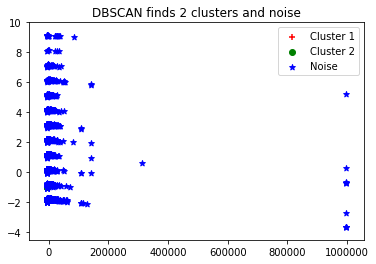

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(cluster_data.drop(['VGNUMMER','inOnderzoek','reg_date'],axis=1).dropna())
pca_2d = pca.transform(cluster_data.drop(['VGNUMMER','inOnderzoek','reg_date'],axis=1).dropna())
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='*')
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Noise'])
plt.title('DBSCAN finds 2 clusters and noise')
plt.show()

In [ ]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

X = StandardScaler().fit_transform(cluster_data.drop(['VGNUMMER','inOnderzoek','reg_date'],axis=1).dropna())

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

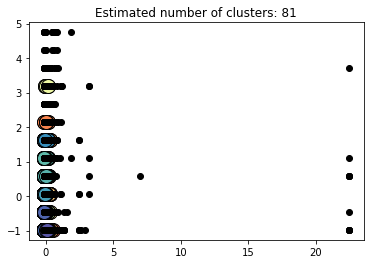

In [22]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()